In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, mean_absolute_percentage_error, r2_score, mean_squared_error

from optuna.samplers import TPESampler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import optuna
from optuna.visualization.matplotlib import plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from tqdm.auto import tqdm
import pickle

import warnings
warnings.filterwarnings('ignore')


In [13]:
NORM_UBP_MAX = 200
NORM_UBP_MIN = 80
NORM_LBP_MAX = 150
NORM_LBP_MIN = 40 
DELTA = 45

MAIN_SEED = 42
np.random.seed(MAIN_SEED)

In [14]:
train = pd.read_csv('Data/TRAIN.csv')
test = pd.read_csv('Data/TEST.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

sample_submission = pd.read_csv('Data/sample_submission.csv')
train.sample(10)

,age,weight,height,sex,stress,doctor,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia
46730,59.603012,64.0,156,1,2,1,1,0,0,140,80,1
48393,59.893224,85.0,170,1,1,1,1,0,0,160,90,1
41416,63.709788,90.0,151,1,1,1,1,0,0,130,80,1
34506,54.047912,97.0,159,1,1,1,1,0,0,120,80,1
43725,50.362765,68.0,164,1,1,1,1,0,0,120,80,0
11615,56.123203,78.0,184,2,1,1,1,0,0,120,80,0
24656,43.857632,60.0,163,1,1,1,1,0,0,120,80,0
22411,49.979466,75.0,176,2,1,1,0,0,0,130,90,1
936,64.082136,90.0,175,2,3,3,1,0,0,160,80,1
56364,57.552361,56.0,145,1,2,1,1,0,0,150,80,0


In [15]:
train['ubp'] = np.abs(train['ubp'])
test['ubp'] = np.abs(test['ubp'])

train['lbp'] = np.abs(train['lbp'])
test['lbp'] = np.abs(test['lbp'])

In [16]:
train[train['ubp'] > NORM_UBP_MAX]['ubp'] = NORM_UBP_MAX
test[test['ubp'] > NORM_UBP_MAX]['ubp'] = NORM_UBP_MAX

train[train['lbp'] > NORM_LBP_MAX]['lbp'] = NORM_LBP_MAX
test[test['lbp'] > NORM_LBP_MAX]['lbp'] = NORM_LBP_MAX

train[train['ubp'] < NORM_UBP_MIN]['ubp'] = NORM_UBP_MIN
test[test['ubp'] < NORM_UBP_MIN]['ubp'] = NORM_UBP_MIN

train[train['lbp'] < NORM_LBP_MIN]['lbp'] = NORM_LBP_MIN
test[test['lbp'] < NORM_LBP_MIN]['lbp'] = NORM_LBP_MIN

In [17]:
#train.loc[((train['ubp'] > NORM_UBP_MAX) | (train['ubp'] < NORM_UBP_MIN)) & ((train['lbp'] < NORM_LBP_MAX) & (train['lbp'] > NORM_LBP_MIN)), 'ubp'] = \
#    train.loc[(((train['ubp'] > NORM_UBP_MAX) | (train['ubp'] < NORM_UBP_MIN)) & ((train['lbp'] < NORM_LBP_MAX) & (train['lbp'] > NORM_LBP_MIN))), 'lbp'] + DELTA

#train.loc[((train['lbp'] > NORM_LBP_MAX) | (train['lbp'] < NORM_LBP_MIN)) & ((train['ubp'] < NORM_UBP_MAX) & (train['ubp'] > NORM_UBP_MIN)), 'lbp'] = \
#    train.loc[((train['lbp'] > NORM_LBP_MAX) | (train['lbp'] < NORM_LBP_MIN)) & ((train['ubp'] < NORM_UBP_MAX) & (train['ubp'] > NORM_UBP_MIN)), 'ubp'] - DELTA


In [18]:
#test.loc[((test['ubp'] > NORM_UBP_MAX) | (test['ubp'] < NORM_UBP_MIN)) & ((test['lbp'] < NORM_LBP_MAX) & (test['lbp'] > NORM_LBP_MIN)), 'ubp'] = \
#    test.loc[(((test['ubp'] > NORM_UBP_MAX) | (test['ubp'] < NORM_UBP_MIN)) & ((test['lbp'] < NORM_LBP_MAX) & (test['lbp'] > NORM_LBP_MIN))), 'lbp'] + DELTA

#test.loc[((test['lbp'] > NORM_LBP_MAX) | (test['lbp'] < NORM_LBP_MIN)) & ((test['ubp'] < NORM_UBP_MAX) & (test['ubp'] > NORM_UBP_MIN)), 'lbp'] = \
#    test.loc[((test['lbp'] > NORM_LBP_MAX) | (test['lbp'] < NORM_LBP_MIN)) & ((test['ubp'] < NORM_UBP_MAX) & (test['ubp'] > NORM_UBP_MIN)), 'ubp'] - DELTA


In [19]:
#train.drop(train[train['ubp'] > 300].index, inplace=True)
#test.drop(test[test['ubp'] > 300].index, inplace=True)
#test.drop(test[test['lbp'] > 300].index, inplace=True)
#train.drop(train[train['lbp'] > 300].index, inplace=True)

#train.drop(train[train['ubp'] < 20].index, inplace=True)
#test.drop(test[test['ubp'] < 20].index, inplace=True)
#test.drop(test[test['lbp'] < 20].index, inplace=True)
#train.drop(train[train['lbp'] < 20].index, inplace=True)

#train.drop('sport', axis=1, inplace=True)
#test.drop('sport', axis=1, inplace=True)

In [20]:
# fix nulls in test

# pernicious_1 & pernicious_2 correlate with *sex* a little 
# so fill nulls with regard to it: 
# 1 for *sex* == 2 and 0, otherwise 
pernicious_1_nan_male = np.where((np.isnan(test['pernicious_1']) & (test['sex']==2)), 
                                  1, 
                                  test['pernicious_1'])
test['pernicious_1'] = pernicious_1_nan_male
test['pernicious_1'] = test['pernicious_1'].fillna(0)

pernicious_2_nan_male = np.where((np.isnan(test['pernicious_2']) & (test['sex']==2)), 
                                  1, 
                                  test['pernicious_2'])
test['pernicious_2'] = pernicious_2_nan_male
test['pernicious_2'] = test['pernicious_2'].fillna(0)

In [21]:
# *sex*: 1/2 -> 0/1

train['sex'] -= 1
test['sex'] -= 1

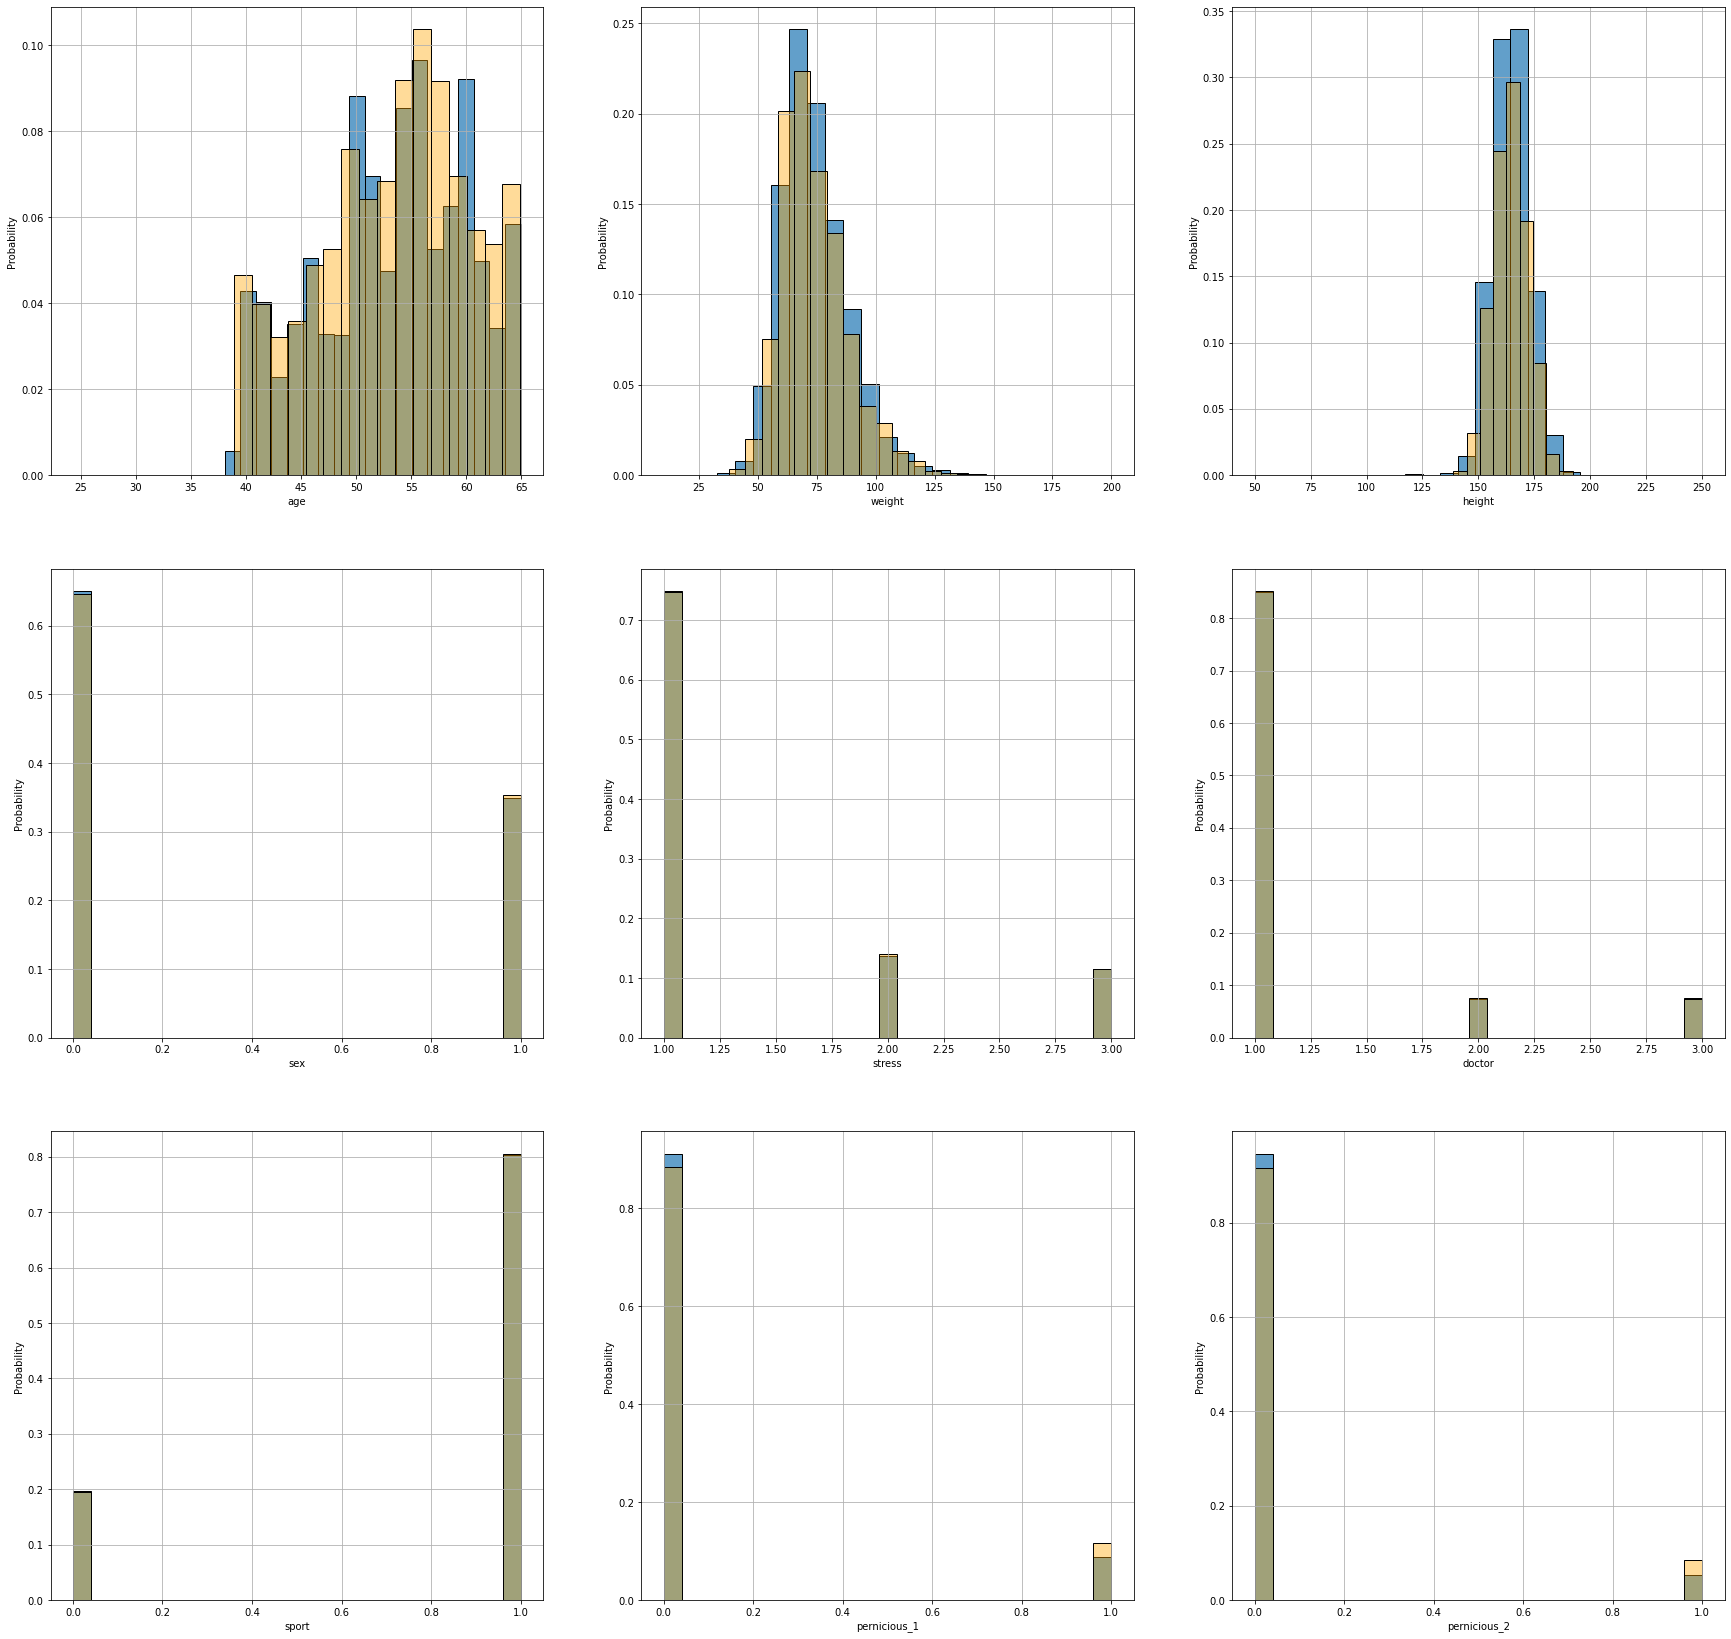

In [22]:
plt.figure(figsize=(30, 50))

for i in range(1, 10):
    plt.subplot(5, 3, i)
    sns.histplot(data=train, x=train.columns[i-1], alpha=0.7, bins=25, stat='probability')
    if i != 12:
        sns.histplot(data=test, x=test.columns[i-1], alpha=0.4, color='orange', bins=25, stat='probability')
    plt.grid()
plt.savefig('Data distribution.pdf', bbox_inches='tight')
plt.show()

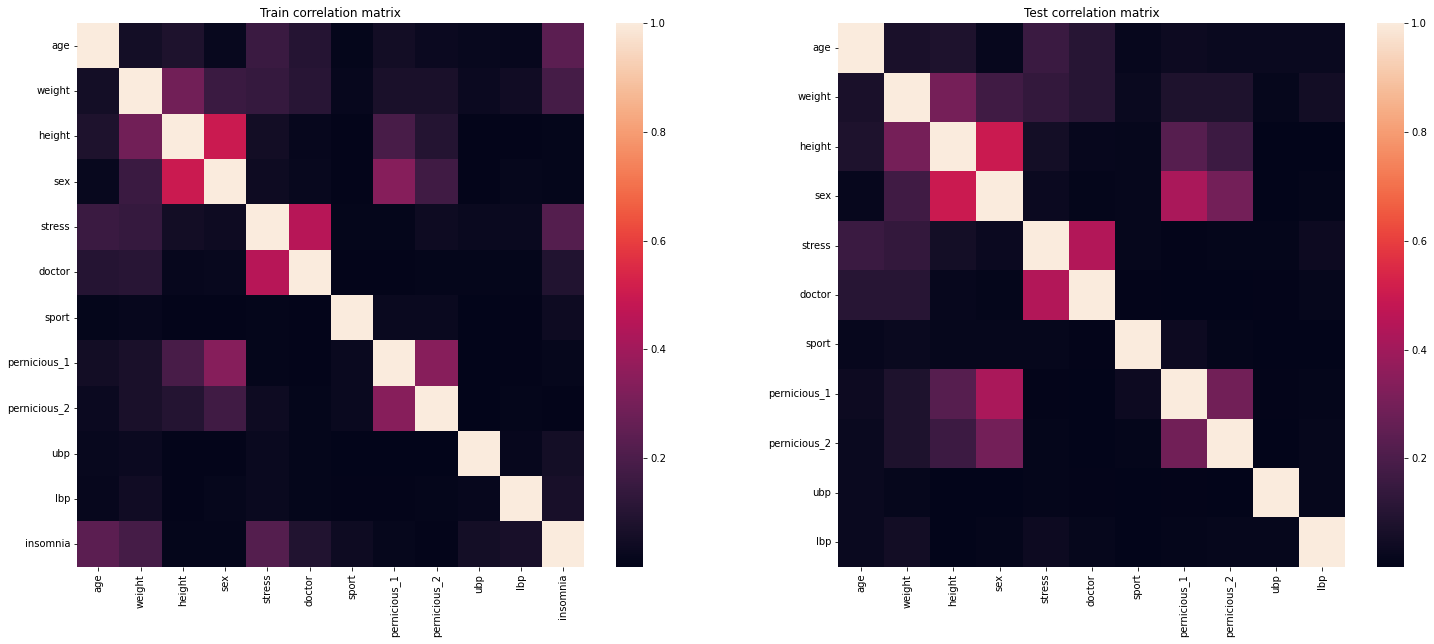

In [23]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.heatmap(np.abs(train.corr()))
plt.title('Train correlation matrix')
plt.subplot(1, 2, 2)
sns.heatmap(np.abs(test.corr()))
plt.title('Test correlation matrix')
plt.savefig('Data correlation.pdf')
plt.show()

In [24]:
# one-hot-encoding categorical features

stress_train_ohe = pd.get_dummies(train['stress'], prefix='stress').drop(columns='stress_3')
stress_test_ohe = pd.get_dummies(test['stress'], prefix='stress').drop(columns='stress_3')

train = train.drop(columns='stress')
test = test.drop(columns='stress')

train = train.join(stress_train_ohe)
test = test.join(stress_test_ohe)

In [25]:
y_train_ = train['insomnia']
train = train.drop(columns=['insomnia'])

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [26]:
# train-test split 

X_train, X_val, y_train, y_val = train_test_split(train, 
                                                  y_train_, 
                                                  test_size=0.3, 
                                                  random_state=MAIN_SEED)

## LGBM

In [27]:
def objective(trial: optuna.Trial):

    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ('gbdt', 'dart', 'goss')),
        #'num_leaves': trial.suggest_int("num_leaves", 2, 1500),
        'n_estimators': trial.suggest_int("n_estimators", 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        #'min_child_samples': trial.suggest_int('min_child_samples', 2, 150),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 1.),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 300),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 1e-5, 1.),
        'objective': 'binary',
        'random_state': MAIN_SEED,
        'n_jobs': -1,
    }

    model = LGBMClassifier(**params)
    
    model.fit(X_train, y_train)
    result = model.predict_proba(X_val)
    score = log_loss(y_val, result)
    return score

In [28]:
sampler = TPESampler(seed=MAIN_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

In [ ]:
study.optimize(objective, n_trials=150, show_progress_bar=True)
best = study.best_params
best_LGBM = best
best['score'] = study.best_value
with open('Models/LGBM_best.pickle', 'wb') as handle:
    pickle.dump(best, handle, protocol=pickle.HIGHEST_PROTOCOL) 
study.best_value

  0%|          | 0/150 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8661774840134774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661774840134774
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


  1%|          | 1/150 [00:02<06:19,  2.55s/it]

[LightGBM] [Warning] feature_fraction is set=0.1834126758083353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1834126758083353
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


  1%|▏         | 2/150 [00:07<10:12,  4.14s/it]

[LightGBM] [Warning] feature_fraction is set=0.3663681796752588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3663681796752588
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


  2%|▏         | 3/150 [00:08<06:29,  2.65s/it]

[LightGBM] [Warning] feature_fraction is set=0.17053241844605468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17053241844605468
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183


  3%|▎         | 4/150 [00:10<05:37,  2.31s/it]

[LightGBM] [Warning] feature_fraction is set=0.44015809221466395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44015809221466395
[LightGBM] [Warning] min_data_in_leaf is set=206, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=206


  3%|▎         | 5/150 [00:11<04:31,  1.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.5200728204975991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5200728204975991
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


  4%|▍         | 6/150 [00:16<07:23,  3.08s/it]

[LightGBM] [Warning] feature_fraction is set=0.9218750162807666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9218750162807666
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180


  5%|▍         | 7/150 [00:18<05:52,  2.47s/it]

[LightGBM] [Warning] feature_fraction is set=0.3567597591603224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567597591603224
[LightGBM] [Warning] min_data_in_leaf is set=249, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=249


  5%|▌         | 8/150 [00:19<04:50,  2.04s/it]

[LightGBM] [Warning] feature_fraction is set=0.1987236943773571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1987236943773571
[LightGBM] [Warning] min_data_in_leaf is set=232, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=232


  6%|▌         | 9/150 [00:21<05:14,  2.23s/it]

[LightGBM] [Warning] feature_fraction is set=0.11587790083453446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11587790083453446
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109


  7%|▋         | 10/150 [00:24<05:16,  2.26s/it]

[LightGBM] [Warning] feature_fraction is set=0.9076657186345649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9076657186345649
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.6873227444483069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6873227444483069
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298


  8%|▊         | 12/150 [00:24<03:05,  1.35s/it]

[LightGBM] [Warning] feature_fraction is set=0.6826481896251468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6826481896251468
[LightGBM] [Warning] min_data_in_leaf is set=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271


  9%|▊         | 13/150 [00:26<02:59,  1.31s/it]

[LightGBM] [Warning] feature_fraction is set=0.7034672322568181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7034672322568181
[LightGBM] [Warning] min_data_in_leaf is set=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299


  9%|▉         | 14/150 [00:26<02:25,  1.07s/it]

[LightGBM] [Warning] feature_fraction is set=0.729912907167533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.729912907167533
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147


 10%|█         | 15/150 [00:27<02:16,  1.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.9958976485339386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9958976485339386
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


 11%|█         | 16/150 [00:27<01:45,  1.27it/s]

[LightGBM] [Warning] feature_fraction is set=0.8123676127061713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8123676127061713
[LightGBM] [Warning] min_data_in_leaf is set=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142


 11%|█▏        | 17/150 [00:31<03:35,  1.62s/it]

[LightGBM] [Warning] feature_fraction is set=0.5705329399171619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5705329399171619
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


 12%|█▏        | 18/150 [00:32<03:33,  1.61s/it]

[LightGBM] [Warning] feature_fraction is set=0.6200654663461138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6200654663461138
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259


 13%|█▎        | 19/150 [00:33<02:39,  1.22s/it]

[LightGBM] [Warning] feature_fraction is set=0.8147178434990533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147178434990533
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126


 13%|█▎        | 20/150 [00:34<02:27,  1.14s/it]

[LightGBM] [Warning] feature_fraction is set=0.779445447343154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779445447343154
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


 14%|█▍        | 21/150 [00:36<03:17,  1.53s/it]

[LightGBM] [Warning] feature_fraction is set=0.8412072803882765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8412072803882765
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171


 15%|█▍        | 22/150 [00:39<04:25,  2.08s/it]

[LightGBM] [Warning] feature_fraction is set=0.6431649853802626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6431649853802626
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146


 15%|█▌        | 23/150 [00:41<04:08,  1.95s/it]

[LightGBM] [Warning] feature_fraction is set=0.6281325772675895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6281325772675895
[LightGBM] [Warning] min_data_in_leaf is set=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224


 16%|█▌        | 24/150 [00:43<03:49,  1.82s/it]

[LightGBM] [Warning] feature_fraction is set=0.6135125543493957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135125543493957
[LightGBM] [Warning] min_data_in_leaf is set=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224


 17%|█▋        | 25/150 [00:44<03:43,  1.79s/it]

[LightGBM] [Warning] feature_fraction is set=0.4468252028921791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4468252028921791
[LightGBM] [Warning] min_data_in_leaf is set=202, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=202


 17%|█▋        | 26/150 [00:45<02:49,  1.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.9215471113456374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215471113456374
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 18%|█▊        | 27/150 [00:45<02:21,  1.15s/it]

[LightGBM] [Warning] feature_fraction is set=0.5326136333436603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326136333436603
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163


 19%|█▊        | 28/150 [00:46<01:57,  1.04it/s]

[LightGBM] [Warning] feature_fraction is set=0.2967871955502427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2967871955502427
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125


 19%|█▉        | 29/150 [00:46<01:43,  1.17it/s]

[LightGBM] [Warning] feature_fraction is set=0.6047817385853831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6047817385853831
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


 20%|██        | 30/150 [00:53<05:17,  2.65s/it]

[LightGBM] [Warning] feature_fraction is set=0.7510907400999028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7510907400999028
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222


 21%|██        | 31/150 [00:54<04:05,  2.06s/it]

[LightGBM] [Warning] feature_fraction is set=0.6646164733336655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6646164733336655
[LightGBM] [Warning] min_data_in_leaf is set=273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=273


 21%|██▏       | 32/150 [00:55<03:39,  1.86s/it]

[LightGBM] [Warning] feature_fraction is set=0.6566009462287707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6566009462287707
[LightGBM] [Warning] min_data_in_leaf is set=261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=261


 22%|██▏       | 33/150 [00:56<03:04,  1.58s/it]

[LightGBM] [Warning] feature_fraction is set=0.4536358547125635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4536358547125635
[LightGBM] [Warning] min_data_in_leaf is set=247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=247


 23%|██▎       | 34/150 [00:57<02:38,  1.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.851995324616944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.851995324616944
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


 23%|██▎       | 35/150 [00:59<02:49,  1.47s/it]

[LightGBM] [Warning] feature_fraction is set=0.6450466642255972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6450466642255972
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197


 24%|██▍       | 36/150 [01:00<02:45,  1.45s/it]

[LightGBM] [Warning] feature_fraction is set=0.5693220492046752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5693220492046752
[LightGBM] [Warning] min_data_in_leaf is set=211, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=211


 25%|██▍       | 37/150 [01:02<03:00,  1.60s/it]

[LightGBM] [Warning] feature_fraction is set=0.5603217674721878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5603217674721878
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215


 25%|██▌       | 38/150 [01:03<02:32,  1.36s/it]

[LightGBM] [Warning] feature_fraction is set=0.47057601420007233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47057601420007233
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187


 26%|██▌       | 39/150 [01:05<02:51,  1.54s/it]

[LightGBM] [Warning] feature_fraction is set=0.9979898978418711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979898978418711
[LightGBM] [Warning] min_data_in_leaf is set=236, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=236


 27%|██▋       | 40/150 [01:05<02:14,  1.22s/it]

[LightGBM] [Warning] feature_fraction is set=0.3831800728884148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3831800728884148
[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276


 27%|██▋       | 41/150 [01:07<02:16,  1.25s/it]

[LightGBM] [Warning] feature_fraction is set=0.02536634487344247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02536634487344247
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=162


 28%|██▊       | 42/150 [01:08<01:59,  1.10s/it]

[LightGBM] [Warning] feature_fraction is set=0.5013017392268848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013017392268848
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190


 29%|██▊       | 43/150 [01:09<02:24,  1.35s/it]

[LightGBM] [Warning] feature_fraction is set=0.5753225654630895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5753225654630895
[LightGBM] [Warning] min_data_in_leaf is set=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242


 29%|██▉       | 44/150 [01:12<02:56,  1.67s/it]

[LightGBM] [Warning] feature_fraction is set=0.7645874117012252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645874117012252
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208


 30%|███       | 45/150 [01:12<02:10,  1.24s/it]

[LightGBM] [Warning] feature_fraction is set=0.8614777587759097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614777587759097
[LightGBM] [Warning] min_data_in_leaf is set=261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=261


 31%|███       | 46/150 [01:13<02:12,  1.27s/it]

[LightGBM] [Warning] feature_fraction is set=0.37326543461477235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37326543461477235
[LightGBM] [Warning] min_data_in_leaf is set=227, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=227


 31%|███▏      | 47/150 [01:19<04:32,  2.64s/it]

[LightGBM] [Warning] feature_fraction is set=0.7147742164713228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147742164713228
[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175


 32%|███▏      | 48/150 [01:20<03:19,  1.95s/it]

[LightGBM] [Warning] feature_fraction is set=0.6481609465228528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6481609465228528
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=283


 33%|███▎      | 49/150 [01:21<03:12,  1.91s/it]

[LightGBM] [Warning] feature_fraction is set=0.5105943201357789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5105943201357789
[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137


 33%|███▎      | 50/150 [01:22<02:36,  1.57s/it]

[LightGBM] [Warning] feature_fraction is set=0.2810059337485366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2810059337485366
[LightGBM] [Warning] min_data_in_leaf is set=257, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=257


 34%|███▍      | 51/150 [01:23<02:17,  1.39s/it]

[LightGBM] [Warning] feature_fraction is set=0.8560918419249015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8560918419249015
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


 35%|███▍      | 52/150 [01:27<03:30,  2.14s/it]

[LightGBM] [Warning] feature_fraction is set=0.9066974201290453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9066974201290453
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


 35%|███▌      | 53/150 [01:28<02:55,  1.81s/it]

[LightGBM] [Warning] feature_fraction is set=0.8002220469704355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8002220469704355
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111


 36%|███▌      | 54/150 [01:31<03:29,  2.18s/it]

[LightGBM] [Warning] feature_fraction is set=0.7258291729449009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7258291729449009
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110


 37%|███▋      | 55/150 [01:35<04:05,  2.58s/it]

[LightGBM] [Warning] feature_fraction is set=0.8840205861306367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8840205861306367
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210


 37%|███▋      | 56/150 [01:38<04:34,  2.92s/it]

[LightGBM] [Warning] feature_fraction is set=0.9600570452050746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600570452050746
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


 38%|███▊      | 57/150 [01:39<03:20,  2.16s/it]

[LightGBM] [Warning] feature_fraction is set=0.6770157487021061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6770157487021061
[LightGBM] [Warning] min_data_in_leaf is set=196, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=196


 39%|███▊      | 58/150 [01:40<02:50,  1.85s/it]

[LightGBM] [Warning] feature_fraction is set=0.543423373592205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.543423373592205
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181


 39%|███▉      | 59/150 [01:45<04:26,  2.93s/it]

[LightGBM] [Warning] feature_fraction is set=0.6001002542785308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001002542785308
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


 40%|████      | 60/150 [01:47<03:53,  2.59s/it]

[LightGBM] [Warning] feature_fraction is set=0.8470819643312384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8470819643312384
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235


 41%|████      | 61/150 [01:48<02:52,  1.94s/it]

[LightGBM] [Warning] feature_fraction is set=0.94863525603532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94863525603532
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


 41%|████▏     | 62/150 [01:50<03:13,  2.19s/it]

[LightGBM] [Warning] feature_fraction is set=0.8250056689194415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8250056689194415
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


 42%|████▏     | 63/150 [01:52<02:54,  2.00s/it]

[LightGBM] [Warning] feature_fraction is set=0.9480642206165296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480642206165296
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


 43%|████▎     | 64/150 [01:54<02:47,  1.94s/it]

[LightGBM] [Warning] feature_fraction is set=0.9551033765492695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9551033765492695
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


 43%|████▎     | 65/150 [01:55<02:31,  1.78s/it]

[LightGBM] [Warning] feature_fraction is set=0.8159985476449438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8159985476449438
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


 44%|████▍     | 66/150 [01:57<02:42,  1.94s/it]

[LightGBM] [Warning] feature_fraction is set=0.8928386201573971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8928386201573971
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


 45%|████▍     | 67/150 [01:59<02:37,  1.90s/it]

[LightGBM] [Warning] feature_fraction is set=0.761293992210335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.761293992210335
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


 45%|████▌     | 68/150 [02:00<02:08,  1.57s/it]

[LightGBM] [Warning] feature_fraction is set=0.8406739916890199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8406739916890199
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


 46%|████▌     | 69/150 [02:03<02:51,  2.11s/it]

[LightGBM] [Warning] feature_fraction is set=0.7939703621996258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7939703621996258
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


 47%|████▋     | 70/150 [02:09<04:01,  3.02s/it]

[LightGBM] [Warning] feature_fraction is set=0.6961531485277115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6961531485277115
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


 47%|████▋     | 71/150 [02:12<04:00,  3.04s/it]

[LightGBM] [Warning] feature_fraction is set=0.7011921725717318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7011921725717318
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


 48%|████▊     | 72/150 [02:15<03:54,  3.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.6951718351233518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6951718351233518
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


 49%|████▊     | 73/150 [02:18<03:59,  3.11s/it]

[LightGBM] [Warning] feature_fraction is set=0.7367927593194012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7367927593194012
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


 49%|████▉     | 74/150 [02:22<04:07,  3.26s/it]

[LightGBM] [Warning] feature_fraction is set=0.7088928869766462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7088928869766462
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


 50%|█████     | 75/150 [02:24<03:53,  3.12s/it]

[LightGBM] [Warning] feature_fraction is set=0.695650659365813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.695650659365813
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


 51%|█████     | 76/150 [02:27<03:43,  3.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.6286331014839096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286331014839096
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


 51%|█████▏    | 77/150 [02:30<03:41,  3.04s/it]

[LightGBM] [Warning] feature_fraction is set=0.5944766646870037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5944766646870037
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


 52%|█████▏    | 78/150 [02:31<02:46,  2.32s/it]

[LightGBM] [Warning] feature_fraction is set=0.6595067024539181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6595067024539181
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


 53%|█████▎    | 79/150 [02:33<02:32,  2.15s/it]

[LightGBM] [Warning] feature_fraction is set=0.6551702261197528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6551702261197528
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 53%|█████▎    | 80/150 [02:34<02:18,  1.98s/it]

[LightGBM] [Warning] feature_fraction is set=0.6718813518084569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6718813518084569
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.6474859569635594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474859569635594
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


 55%|█████▍    | 82/150 [02:36<01:33,  1.38s/it]

[LightGBM] [Warning] feature_fraction is set=0.580465496327779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.580465496327779
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


 55%|█████▌    | 83/150 [02:38<01:55,  1.73s/it]

[LightGBM] [Warning] feature_fraction is set=0.5504678709712235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5504678709712235
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


 56%|█████▌    | 84/150 [02:41<02:03,  1.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.6908387607085941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6908387607085941
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


 57%|█████▋    | 85/150 [02:42<01:53,  1.74s/it]

[LightGBM] [Warning] feature_fraction is set=0.6209771189185996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6209771189185996
[LightGBM] [Warning] min_data_in_leaf is set=291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=291


 57%|█████▋    | 86/150 [02:43<01:43,  1.61s/it]

[LightGBM] [Warning] feature_fraction is set=0.749923296812772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749923296812772
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


 58%|█████▊    | 87/150 [02:44<01:20,  1.28s/it]

[LightGBM] [Warning] feature_fraction is set=0.6639729816658705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6639729816658705
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


 59%|█████▊    | 88/150 [02:44<01:02,  1.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.6274520061477294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6274520061477294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


 59%|█████▉    | 89/150 [02:46<01:12,  1.19s/it]

[LightGBM] [Warning] feature_fraction is set=0.4138156090725757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4138156090725757
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


 60%|██████    | 90/150 [02:47<01:19,  1.32s/it]

[LightGBM] [Warning] feature_fraction is set=0.4770159330563489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4770159330563489
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


 61%|██████    | 91/150 [02:50<01:41,  1.71s/it]

[LightGBM] [Warning] feature_fraction is set=0.716620382214004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716620382214004
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


 61%|██████▏   | 92/150 [02:52<01:45,  1.82s/it]

[LightGBM] [Warning] feature_fraction is set=0.7806448237164392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806448237164392
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


 62%|██████▏   | 93/150 [02:55<01:57,  2.07s/it]

[LightGBM] [Warning] feature_fraction is set=0.7840849972994531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7840849972994531
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


 63%|██████▎   | 94/150 [02:57<02:01,  2.16s/it]

[LightGBM] [Warning] feature_fraction is set=0.7405049236547563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7405049236547563
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


 63%|██████▎   | 95/150 [03:00<02:08,  2.33s/it]

[LightGBM] [Warning] feature_fraction is set=0.6616648048326296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616648048326296
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


 64%|██████▍   | 96/150 [03:02<01:55,  2.15s/it]

[LightGBM] [Warning] feature_fraction is set=0.5261442198909181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5261442198909181
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 65%|██████▍   | 97/150 [03:02<01:30,  1.70s/it]

[LightGBM] [Warning] feature_fraction is set=0.6955923758713249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6955923758713249
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215


 65%|██████▌   | 98/150 [03:05<01:47,  2.06s/it]

[LightGBM] [Warning] feature_fraction is set=0.7747647477778115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747647477778115
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


 66%|██████▌   | 99/150 [03:07<01:49,  2.14s/it]

[LightGBM] [Warning] feature_fraction is set=0.7842929162274564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842929162274564
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


 67%|██████▋   | 100/150 [03:10<02:00,  2.41s/it]

[LightGBM] [Warning] feature_fraction is set=0.7703006719096633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7703006719096633
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


 67%|██████▋   | 101/150 [03:12<01:46,  2.17s/it]

[LightGBM] [Warning] feature_fraction is set=0.8175426146756775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175426146756775
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


 68%|██████▊   | 102/150 [03:15<01:54,  2.38s/it]

[LightGBM] [Warning] feature_fraction is set=0.8284888841851521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8284888841851521
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


 69%|██████▊   | 103/150 [03:18<01:57,  2.50s/it]

[LightGBM] [Warning] feature_fraction is set=0.8282941411403737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282941411403737
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


 69%|██████▉   | 104/150 [03:20<01:55,  2.51s/it]

[LightGBM] [Warning] feature_fraction is set=0.8210861145937733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8210861145937733
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


 70%|███████   | 105/150 [03:23<01:57,  2.60s/it]

[LightGBM] [Warning] feature_fraction is set=0.8324041841238285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8324041841238285
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


 71%|███████   | 106/150 [03:25<01:45,  2.39s/it]

[LightGBM] [Warning] feature_fraction is set=0.8747427995216279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8747427995216279
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


 71%|███████▏  | 107/150 [03:28<01:52,  2.62s/it]

[LightGBM] [Warning] feature_fraction is set=0.7971016677834764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7971016677834764
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


 72%|███████▏  | 108/150 [03:29<01:22,  1.96s/it]

[LightGBM] [Warning] feature_fraction is set=0.8757844141983476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757844141983476
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 73%|███████▎  | 109/150 [03:32<01:41,  2.48s/it]

[LightGBM] [Warning] feature_fraction is set=0.8811434883997242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8811434883997242
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 73%|███████▎  | 110/150 [03:37<02:03,  3.08s/it]

[LightGBM] [Warning] feature_fraction is set=0.9145304595670405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9145304595670405
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


 74%|███████▍  | 111/150 [03:39<01:56,  2.98s/it]

[LightGBM] [Warning] feature_fraction is set=0.8979777127489361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8979777127489361
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


 75%|███████▍  | 112/150 [03:42<01:49,  2.89s/it]

[LightGBM] [Warning] feature_fraction is set=0.9263479474222878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263479474222878
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


 75%|███████▌  | 113/150 [03:45<01:47,  2.91s/it]

[LightGBM] [Warning] feature_fraction is set=0.9198822591020195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9198822591020195
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


 76%|███████▌  | 114/150 [03:48<01:43,  2.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.9189058349684779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9189058349684779
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


 77%|███████▋  | 115/150 [03:51<01:41,  2.90s/it]

[LightGBM] [Warning] feature_fraction is set=0.9226390192221607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9226390192221607
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


 77%|███████▋  | 116/150 [03:54<01:42,  3.02s/it]

[LightGBM] [Warning] feature_fraction is set=0.9222314035067469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222314035067469
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


 78%|███████▊  | 117/150 [03:56<01:32,  2.80s/it]

[LightGBM] [Warning] feature_fraction is set=0.9794849674180097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9794849674180097
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


 79%|███████▊  | 118/150 [03:59<01:22,  2.59s/it]

[LightGBM] [Warning] feature_fraction is set=0.9234288401966597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9234288401966597
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


 79%|███████▉  | 119/150 [04:01<01:22,  2.66s/it]

[LightGBM] [Warning] feature_fraction is set=0.902859771660648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.902859771660648
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


 80%|████████  | 120/150 [04:02<01:01,  2.05s/it]

[LightGBM] [Warning] feature_fraction is set=0.9699200570221075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9699200570221075
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


 81%|████████  | 121/150 [04:04<01:01,  2.12s/it]

[LightGBM] [Warning] feature_fraction is set=0.9292470550484008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292470550484008
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


 81%|████████▏ | 122/150 [04:07<01:06,  2.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.9374831143910458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9374831143910458
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


 82%|████████▏ | 123/150 [04:10<01:08,  2.54s/it]

[LightGBM] [Warning] feature_fraction is set=0.9260793185958792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9260793185958792
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


 83%|████████▎ | 124/150 [04:13<01:08,  2.64s/it]

[LightGBM] [Warning] feature_fraction is set=0.8600713264539943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600713264539943
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


 83%|████████▎ | 125/150 [04:15<00:58,  2.34s/it]

[LightGBM] [Warning] feature_fraction is set=0.9448625781852197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9448625781852197
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


 84%|████████▍ | 126/150 [04:18<01:03,  2.66s/it]

[LightGBM] [Warning] feature_fraction is set=0.9913952759758605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9913952759758605
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


 85%|████████▍ | 127/150 [04:21<01:01,  2.66s/it]

[LightGBM] [Warning] feature_fraction is set=0.9871246285667685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9871246285667685
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


 85%|████████▌ | 128/150 [04:23<00:53,  2.44s/it]

[LightGBM] [Warning] feature_fraction is set=0.870761147004014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.870761147004014
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


 86%|████████▌ | 129/150 [04:26<00:55,  2.63s/it]

[LightGBM] [Warning] feature_fraction is set=0.9380324497688702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380324497688702
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


 87%|████████▋ | 130/150 [04:26<00:39,  1.98s/it]

[LightGBM] [Warning] feature_fraction is set=0.9986650510960358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986650510960358
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


 87%|████████▋ | 131/150 [04:30<00:46,  2.46s/it]

[LightGBM] [Warning] feature_fraction is set=0.8701333898250531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8701333898250531
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


 88%|████████▊ | 132/150 [04:33<00:46,  2.59s/it]

[LightGBM] [Warning] feature_fraction is set=0.8708581855404541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8708581855404541
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


 89%|████████▊ | 133/150 [04:36<00:45,  2.70s/it]

[LightGBM] [Warning] feature_fraction is set=0.9663789067432538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9663789067432538
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


 89%|████████▉ | 134/150 [04:38<00:39,  2.48s/it]

[LightGBM] [Warning] feature_fraction is set=0.9059255508189773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9059255508189773
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


 90%|█████████ | 135/150 [04:41<00:40,  2.72s/it]

[LightGBM] [Warning] feature_fraction is set=0.8994390523805564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8994390523805564
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


 91%|█████████ | 136/150 [04:45<00:44,  3.18s/it]

[LightGBM] [Warning] feature_fraction is set=0.9125433316958298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9125433316958298
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


 91%|█████████▏| 137/150 [04:47<00:37,  2.92s/it]

[LightGBM] [Warning] feature_fraction is set=0.8790470568657813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8790470568657813
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


 92%|█████████▏| 138/150 [04:52<00:40,  3.34s/it]

[LightGBM] [Warning] feature_fraction is set=0.860415835954988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860415835954988
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


 93%|█████████▎| 139/150 [04:54<00:33,  3.05s/it]

[LightGBM] [Warning] feature_fraction is set=0.962538026981155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.962538026981155
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 93%|█████████▎| 140/150 [05:00<00:40,  4.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.9164762546989467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9164762546989467
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


 94%|█████████▍| 141/150 [05:03<00:32,  3.67s/it]

[LightGBM] [Warning] feature_fraction is set=0.9137726463998683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9137726463998683
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


 95%|█████████▍| 142/150 [05:06<00:26,  3.30s/it]

[LightGBM] [Warning] feature_fraction is set=0.8873371531914449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873371531914449
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


 95%|█████████▌| 143/150 [05:09<00:23,  3.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.8495948260477355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8495948260477355
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


 96%|█████████▌| 144/150 [05:11<00:16,  2.82s/it]

[LightGBM] [Warning] feature_fraction is set=0.8111328724255604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111328724255604
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


In [30]:
study.best_trial

FrozenTrial(number=112, values=[0.5365081838384128], datetime_start=datetime.datetime(2021, 12, 5, 0, 35, 4, 81092), datetime_complete=datetime.datetime(2021, 12, 5, 0, 35, 7, 33789), params={'boosting_type': 'dart', 'n_estimators': 432, 'max_depth': 3, 'learning_rate': 0.26998733934256397, 'min_data_in_leaf': 24, 'feature_fraction': 0.9263479474222878}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart', 'goss')), 'n_estimators': IntUniformDistribution(high=500, low=10, step=1), 'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'learning_rate': UniformDistribution(high=1.0, low=1e-05), 'min_data_in_leaf': IntUniformDistribution(high=300, low=2, step=1), 'feature_fraction': UniformDistribution(high=1.0, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=112, state=TrialState.COMPLETE, value=None)

<Figure size 720x360 with 0 Axes>

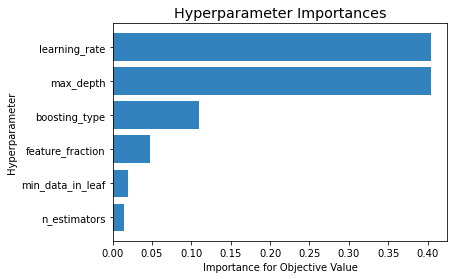

In [31]:
plt.figure(figsize=(10, 5))
plot_param_importances(study)
plt.show()

## XGBoost

In [32]:
def objective(trial: optuna.Trial):

    params = {
        'eta': trial.suggest_uniform('eta', 1e-4, 1.),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0, 1.),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1.),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': MAIN_SEED
    }

    model = XGBClassifier(**params)
    
    model.fit(X_train, y_train)
    result = model.predict_proba(X_val)
    score = log_loss(y_val, result)
    return score

In [33]:
sampler = TPESampler(seed=MAIN_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

In [34]:
study.optimize(objective, n_trials=150, show_progress_bar=True)
best = study.best_params
best_XGB = best
best['score'] = study.best_value
with open('Models/XGB_best.pickle', 'wb') as handle:
    pickle.dump(best, handle, protocol=pickle.HIGHEST_PROTOCOL) 
best

100%|██████████| 150/150 [04:03<00:00,  1.63s/it]


{'eta': 0.44435710910403586,
 'max_depth': 3,
 'subsample': 0.9559540431682495,
 'colsample_bytree': 0.3553737445494191,
 'score': 0.5384738084234829}

In [35]:
best

{'eta': 0.44435710910403586,
 'max_depth': 3,
 'subsample': 0.9559540431682495,
 'colsample_bytree': 0.3553737445494191,
 'score': 0.5384738084234829}

<Figure size 720x360 with 0 Axes>

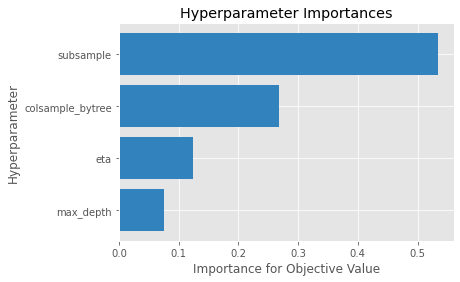

In [36]:
plt.figure(figsize=(10, 5))
plot_param_importances(study)
plt.show()

## CatBoost

In [37]:
def objective(trial: optuna.Trial):

    params = {
        'iterations': trial.suggest_int('iterations', 20, 500),
        'depth': trial.suggest_int('depth', 3, 7),
        'silent': True,
        'random_seed': MAIN_SEED,
        'loss_function': 'Logloss',
        'task_type': 'GPU'
    }

    model = CatBoostClassifier(**params)
    
    model.fit(X_train, y_train)
    result = model.predict_proba(X_val)[:, 1]
    score = log_loss(y_val, result)
    return score

In [38]:
sampler = TPESampler(seed=MAIN_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

In [39]:
study.optimize(objective, n_trials=150, show_progress_bar=True)
best = study.best_params
best_Cat = best
best['score'] = study.best_value
with open('Models/Catboost_best.pickle', 'wb') as handle:
    pickle.dump(best, handle, protocol=pickle.HIGHEST_PROTOCOL) 
best

100%|██████████| 150/150 [11:35<00:00,  4.64s/it]


{'iterations': 449, 'depth': 4, 'score': 0.535972767360397}

<Figure size 720x360 with 0 Axes>

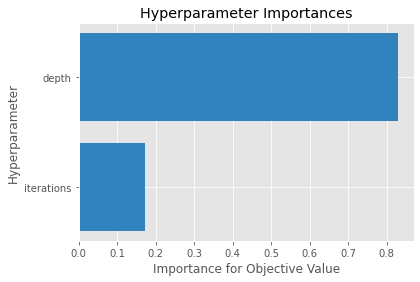

In [40]:
plt.figure(figsize=(10, 5))
plot_param_importances(study)
plt.show()

In [58]:
params_LGBM = {
    'objective': 'binary',
    'random_state': MAIN_SEED,
    'n_jobs': -1,
}

for key in best_LGBM:
    params_LGBM[key] = best_LGBM[key]

model_LGBM = LGBMClassifier(**params_LGBM)

params_XGB = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': MAIN_SEED
}

for key in best_XGB:
    params_XGB[key] = best_XGB[key]

model_XGB = XGBClassifier(**params_XGB)

params_CAT = {
    'random_seed': MAIN_SEED,
    'loss_function': 'Logloss',
    'task_type': 'GPU'
}

for key in best_Cat:
    params_CAT[key] = best_Cat[key]

model_Cat = CatBoostClassifier(**params_CAT)

In [74]:
best_Cat

{'iterations': 449, 'depth': 4}

In [59]:
model_LGBM.fit(train, y_train_)
model_XGB.fit(train, y_train_)
model_Cat.fit(train, y_train_)

[00:59:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Learning rate set to 0.054687
0:	learn: 0.6777693	total: 6.41ms	remaining: 2.87s
1:	learn: 0.6641492	total: 12.9ms	remaining: 2.88s
2:	learn: 0.6521222	total: 19.3ms	remaining: 2.87s
3:	learn: 0.6414095	total: 25.4ms	remaining: 2.83s
4:	learn: 0.6320007	total: 31.3ms	remaining: 2.78s
5:	learn: 0.6237813	total: 37.6ms	remaining: 2.78s
6:	learn: 0.6164951	total: 44.2ms	remaining: 2.79s
7:	learn: 0.6099392	total: 50.6ms	remaining: 2.79s
8:	learn: 0.6039879	total: 56.3ms	remaining: 2.75s
9:	learn: 0.5986674	total: 62ms	remaining: 2.72s
10:	learn: 0.5940910	total: 67.6ms	remaining: 2.69s
11:	learn: 0.5900

In [71]:
pred_LGBM = model_LGBM.predict_proba(test)[:, 1]
pred_XGB = model_XGB.predict_proba(test)[:, 1]
pred_Cat = model_Cat.predict_proba(test)[:, 1]

In [72]:
prediction = pred_LGBM * 0.2 + pred_XGB * 0.2 + pred_Cat * 0.6

In [73]:
test_submission = pd.DataFrame(sample_submission['id'])
test_submission['insomnia'] = prediction
test_submission.to_csv('test_submission_ensemble.csv', index=False)